<a href="https://colab.research.google.com/github/ArihantRS/Diseases/blob/main/Diseases_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Dataset.zip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions
from tensorflow.keras.utils import img_to_array, load_img

In [4]:
len(os.listdir("/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"))

38

In [6]:
train_datagen=ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train=train_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",target_size=(256,256),batch_size=32)
val=val_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",target_size=(256,256),batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
t_img, label =train.next()

In [9]:
def plotImage(img_arr,label):

  for im,l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.imshow(im/255)
    plt.show()

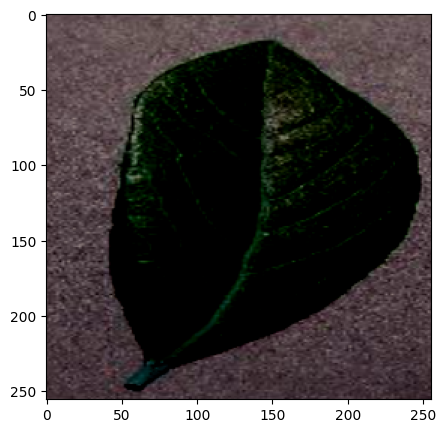

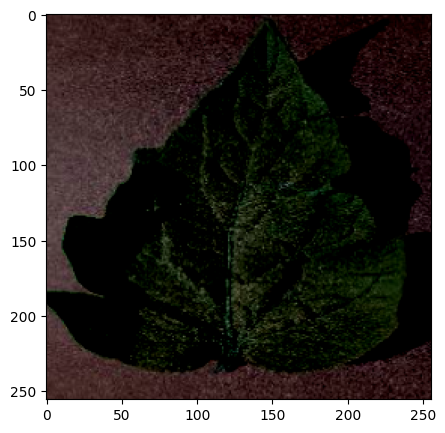

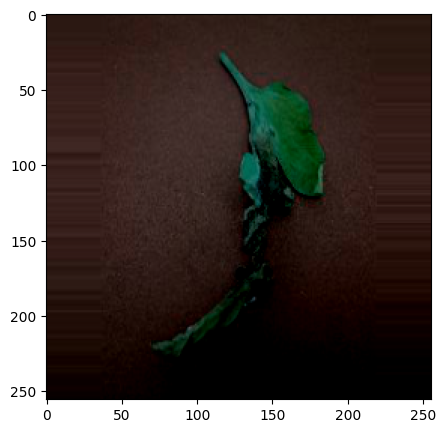

In [10]:
plotImage(t_img[:3],label[:3])

# Builing the model

In [11]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [12]:
base_model= VGG19(input_shape=(256,256,3),include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [13]:
for layer in base_model.layers:
  layer.trainable= False

In [14]:
x=Flatten()(base_model.output)

x=Dense(units= 38, activation='softmax')(x)

#Model
model= Model(base_model.input,x)

In [15]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

#Early Stopping and Model Checkpoint


In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#es
es= EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
#MC
mc=ModelCheckpoint(filepath="best_model.h5",monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only=True)

cb=[es,mc]

In [18]:
his=model.fit_generator(train,steps_per_epoch=16,
                        epochs=50,
                        verbose=1,
                        callbacks=cb,validation_data=val,
                        validation_steps=16)

<ipython-input-18-6f606093cbc4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his=model.fit_generator(train,steps_per_epoch=16,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 24.4489 - accuracy: 0.1992
Epoch 1: val_accuracy improved from -inf to 0.36719, saving model to best_model.h5
16/16 [==============================] - 30s 989ms/step - loss: 24.4489 - accuracy: 0.1992 - val_loss: 14.9433 - val_accuracy: 0.3672
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 16.7071 - accuracy: 0.3965
Epoch 2: val_accuracy improved from 0.36719 to 0.51172, saving model to best_model.h5
16/16 [==============================] - 14s 913ms/step - loss: 16.7071 - accuracy: 0.3965 - val_loss: 13.3978 - val_accuracy: 0.5117
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 10.9009 - accuracy: 0.5664
Epoch 3: val_accuracy improved from 0.51172 to 0.68164, saving model to best_model.h5
16/16 [==============================] - 15s 960ms/step - loss: 10.9009 - accuracy: 0.5664 - val_loss: 6.7232 - val_accuracy: 0.6816
Epoch 4/50
16/16 [==============================] - ETA: 0s

In [ ]:
h=his.history
h.keys()

dict_keys(['loss','accuracy','val_loss','val_accuracy'])

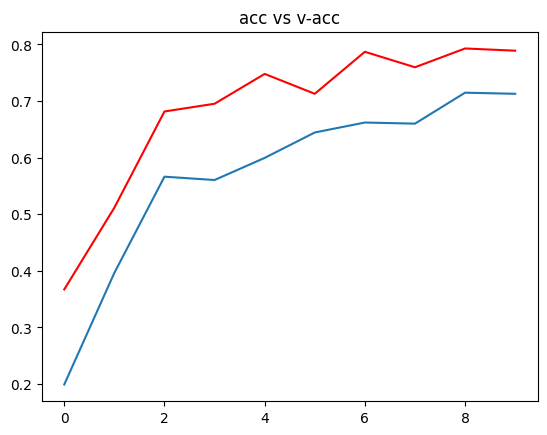

In [22]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title('acc vs v-acc')
plt.show()

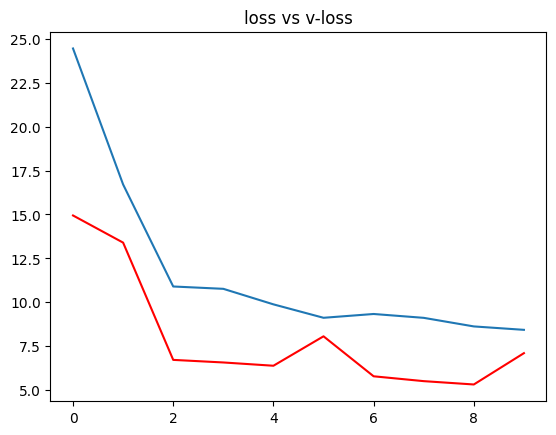

In [23]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title('loss vs v-loss')
plt.show()

In [24]:
# load best model

from keras.models import load_model
model=load_model("/content/best_model.h5")

In [25]:
acc=model.evaluate_generator(val)[1]

print(f"the accuracy of your model is = {acc*100} %")

<ipython-input-25-9f1c8659835e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(val)[1]


the accuracy of your model is = 77.07716822624207 %


In [44]:
def prediction(path):
  img=load_img(path,target_size=(256,256))
  i=img_to_array(img)

  im=preprocess_input(i)
  img=np.expand_dims(im,axis=0)

  pred=np.argmax(model.predict(img))

  print(f"image belongs to {ref[pred]}")



In [46]:
ref=dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [48]:
path="/content/test/test/CornCommonRust1.JPG"
prediction(path)

1/1 [==============================] - 0s 29ms/step
image belongs to Corn_(maize)___Common_rust_
